### 1. Configuração do ambiente e carregamento de dados

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# Carregamento da tabela principal
caminho = '../data/raw/dados_brutos.csv'
df_psico = pd.read_csv(caminho)

In [5]:
# Carregamento de dicionários
dic_sid = pd.read_csv('../data/dicionarios/br_bd_diretorios_brasil_cid_10.csv')
dic_municipio = pd.read_csv('../data/dicionarios/br_bd_diretorios_brasil_municipio.csv')
dic_geral = pd.read_csv('../data/dicionarios/br_ms_sia_dicionario.csv')

### 2. Entendimento e limpeza de dados

#### 2.1. Limpeza inicial dos dados

In [6]:
df_psico.columns

Index(['ano', 'mes', 'sigla_uf', 'id_municipio', 'id_estabelecimento_cnes',
       'id_estabelecimento_cnes_familia', 'id_procedimento_ambulatorial',
       'id_servico_especializado', 'id_classificacao_servico',
       'data_inicio_atendimento', 'data_termino_atendimento',
       'permanencia_atendimento', 'motivo_saida_permanencia',
       'data_motivo_saida_permanencia', 'ano_processamento',
       'mes_processamento', 'ano_atendimento', 'mes_atendimento',
       'data_nascimento_paciente', 'id_municipio_residencia_paciente',
       'origem_paciente', 'nacionalidade_paciente', 'tipo_idade',
       'idade_paciente', 'sexo_paciente', 'raca_cor_paciente',
       'etnia_paciente', 'carater_atendimento', 'cid_principal_categoria',
       'cid_principal_subcategoria', 'cid_causas_associadas_categoria',
       'cid_causas_associadas_subcategoria', 'tipo_droga', 'destino_paciente',
       'local_realizacao_atendimento', 'indicador_situacao_rua',
       'indicador_estrategia_familia', 'quant

In [7]:
df_psico.shape

(3717639, 41)

In [8]:
df_psico['ano_atendimento'].unique()

array([2012, 2014, 2015, 2017, 2018, 2019, 2021, 2013, 2016, 2022, 2023,
       2020, 2024, 2025])

In [9]:
# Remoção de anos menores que 2014 e maiores que 2024 (fora da série temporal da análise):
anos_remover = [2012, 2013, 2025]

df_psico = df_psico[~df_psico['ano_atendimento'].isin(anos_remover)]

Verificação e tratamento de nulos

In [10]:
nulos = (df_psico.isnull().sum() / len(df_psico)) * 100 
colunas_nulas = nulos[nulos > 0].sort_values(ascending=False)

print("Percentual de valores nulos por coluna:")
print(colunas_nulas)

Percentual de valores nulos por coluna:
indicador_situacao_rua                100.000000
indicador_estrategia_familia          100.000000
data_motivo_saida_permanencia          98.490448
cid_causas_associadas_categoria        97.649287
cid_causas_associadas_subcategoria     93.884226
data_inicio_atendimento                79.061244
data_termino_atendimento               79.061244
cid_principal_categoria                63.873240
cid_principal_subcategoria             36.126760
dtype: float64


Remoção de colunas mais de 70% nulas e tratamento das colunas referentes ao CID pois fazem parte da análise

In [11]:
df_psico['cid_paciente'] = df_psico['cid_principal_subcategoria'].fillna(df_psico['cid_principal_categoria'])

In [12]:
df_psico['cid_paciente'].isnull().mean().round(2)

np.float64(0.0)

In [13]:
df_psico = df_psico.drop(columns=['cid_principal_categoria', 'cid_principal_subcategoria'])

In [14]:
# Remoção de colunas nulas e que não são necessárias para análise
remover = ['indicador_situacao_rua', 'indicador_estrategia_familia', 'data_motivo_saida_permanencia', 'cid_causas_associadas_categoria', 
           'cid_causas_associadas_subcategoria', 'local_realizacao_atendimento', 'quantidade_atendimentos', 'sigla_uf', 
           'nacionalidade_paciente', 'origem_paciente',  'tipo_idade', 'ano_processamento', 'id_estabelecimento_cnes', 
           'id_estabelecimento_cnes_familia', 'id_classificacao_servico', 'mes_processamento','data_inicio_atendimento', 
           'data_termino_atendimento', 'permanencia_atendimento', 'motivo_saida_permanencia', 'etnia_paciente',
           'carater_atendimento', 'tipo_droga', 'destino_paciente', 'ano', 'mes', 'id_servico_especializado'
           ]
df_psico = df_psico.drop(columns=remover)

In [15]:
df_psico.columns

Index(['id_municipio', 'id_procedimento_ambulatorial', 'ano_atendimento',
       'mes_atendimento', 'data_nascimento_paciente',
       'id_municipio_residencia_paciente', 'idade_paciente', 'sexo_paciente',
       'raca_cor_paciente', 'quantidade_produzida_procedimento',
       'quantidade_aprovada_procedimento', 'quantidade_pacientes',
       'cid_paciente'],
      dtype='object')

In [16]:
df_psico = df_psico[df_psico['quantidade_aprovada_procedimento'] > 0].copy()

In [17]:
df_psico = df_psico[df_psico['quantidade_pacientes'] == 1].copy()

In [18]:
df_psico.head()

,id_municipio,id_procedimento_ambulatorial,ano_atendimento,mes_atendimento,data_nascimento_paciente,id_municipio_residencia_paciente,idade_paciente,sexo_paciente,raca_cor_paciente,quantidade_produzida_procedimento,quantidade_aprovada_procedimento,quantidade_pacientes,cid_paciente
5,4125506,301080208,2014,2,1986-09-09,4125506,27,M,99,1,1,1,F102
6,4113205,301080240,2014,2,1967-01-27,4113205,46,M,3,1,1,1,F102
7,4119509,301080194,2014,2,1980-04-09,4119509,33,F,3,1,1,1,F430
8,4119509,301080208,2014,2,1973-07-14,4119509,39,F,3,1,1,1,F45
9,4119509,301080194,2014,2,1954-10-23,4119509,59,F,3,1,1,1,F32


In [28]:
print(df_psico['idade_paciente'].isnull().sum())
print(df_psico['sexo_paciente'].isnull().sum())
print(df_psico['data_nascimento_paciente'].isnull().sum())

0
0
0


#### 2.2. Junção com dicionários

In [19]:
# Municípios
dic_nomes = dic_municipio.set_index('id_municipio')['nome']

# adiciona nome dos municípios de atendimento para a tabela inicial
df_psico['municipio_atendimento'] = df_psico['id_municipio'].map(dic_nomes)

# adiciona nome dos municípios de residencia dos pacientes para a tabela inicial
df_psico['municipio_residencia'] = df_psico['id_municipio_residencia_paciente'].map(dic_nomes)

In [20]:
df_psico = df_psico.drop(columns=['id_municipio', 'id_municipio_residencia_paciente'])

In [21]:
colunas_chave = ['nome_coluna', 'chave']
dic_geral = dic_geral.drop_duplicates(subset=colunas_chave, keep='first')

In [22]:
raca_cor = dic_geral[dic_geral['nome_coluna'] == 'raca_cor_paciente']
mapa = raca_cor.set_index('chave')['valor']
df_psico['raca_cor_paciente'] = df_psico['raca_cor_paciente'].astype(str).map(mapa)

Remoção de pacientes que não são residentes de Curitiba e Região Metropolitana

In [23]:

df_municipios_validos = ['Curitiba', 'Adrianópolis', 'Agudos do Sul', 'Almirante Tamandaré', 'Araucária', 'Balsa Nova','Bocaiúva do Sul', 
                         'Campina Grande do Sul', 'Campo do Tenente','Campo Largo', 'Campo Magro', 'Cerro Azul', 'Colombo', 'Contenda', 
                         'Doutor Ulysses', 'Fazenda Rio Grande', 'Itaperuçu', 'Lapa', 'Mandirituba', 'Piên', 'Pinhais', 'Piraquara', 'Quatro Barras', 
                         'Rio Branco do Sul', 'Rio Negro', 'São José dos Pinhais', 'Quitandinha', 'Tijucas do Sul', 'Tunas do Paraná']

df_psico = df_psico[df_psico['municipio_residencia'].isin(df_municipios_validos)]

#### 2.3. Análise descritiva dos dados

Análise descritiva dos dados, identificação de inconsistencias, outliners, entre outros.

In [30]:
df_psico.shape

(651745, 13)

In [31]:
df_psico['raca_cor_paciente'].unique()

array(['sem informacao', 'parda', 'branca', 'preta', 'amarela',
       'indigena'], dtype=object)

In [32]:
df_psico['raca_cor_paciente'] = df_psico['raca_cor_paciente'].replace('sem informacao', 'não declarado') 

Análise etária dos pacientes

In [33]:
idades = df_psico['idade_paciente'].sort_values(ascending=True)
print(idades)

557837      0
3588033     0
2027025     0
57060       0
3644747     0
           ..
2978600    96
3655786    96
3663119    96
1957389    96
1258024    97
Name: idade_paciente, Length: 651745, dtype: int64


In [39]:
pacientes = df_psico[df_psico['idade_paciente'] == 1]
columns = ['ano_atendimento', 'data_nascimento_paciente', 'idade_paciente']

pacientes[columns].head()

,ano_atendimento,data_nascimento_paciente,idade_paciente
2253,2014,2014-07-13,1
4782,2017,2015-02-27,1
10665,2021,1986-02-12,1
19213,2022,2019-05-10,1
43905,2015,2015-03-01,1


Há algumas inconsistencias entre a idade do paciente e a data de nascimento

Correção no calculo das idades:

In [40]:
df_psico['data_nascimento_paciente'] = pd.to_datetime(df_psico['data_nascimento_paciente'])

df_datas_atendimento = pd.DataFrame ({ 'year': df_psico['ano_atendimento'], 'month': df_psico['mes_atendimento'], 'day': 1})
df_psico['data_atendimento'] = pd.to_datetime(df_datas_atendimento)

idade = df_psico['data_atendimento'].dt.year - df_psico['data_nascimento_paciente'].dt.year

ajuste = np.where ((df_psico['data_atendimento'].dt.month < df_psico['data_nascimento_paciente'].dt.month) |
    ((df_psico['data_atendimento'].dt.month == df_psico['data_nascimento_paciente'].dt.month) &
     (df_psico['data_atendimento'].dt.day < df_psico['data_nascimento_paciente'].dt.day) ),
      1, 0)

df_psico['idade_paciente'] = idade - ajuste

In [51]:
df_psico.head()

,id_procedimento_ambulatorial,ano_atendimento,mes_atendimento,data_nascimento_paciente,idade_paciente,sexo_paciente,raca_cor_paciente,quantidade_produzida_procedimento,quantidade_aprovada_procedimento,quantidade_pacientes,cid_paciente,municipio_atendimento,municipio_residencia,data_atendimento
5,301080208,2014,2,1986-09-09,27,M,não declarado,1,1,1,F102,São José dos Pinhais,São José dos Pinhais,2014-02-01
6,301080240,2014,2,1967-01-27,47,M,parda,1,1,1,F102,Lapa,Lapa,2014-02-01
7,301080194,2014,2,1980-04-09,33,F,parda,1,1,1,F430,Piraquara,Piraquara,2014-02-01
8,301080208,2014,2,1973-07-14,40,F,parda,1,1,1,F45,Piraquara,Piraquara,2014-02-01
9,301080194,2014,2,1954-10-23,59,F,parda,1,1,1,F32,Piraquara,Piraquara,2014-02-01


In [53]:
df_psico.shape

(651745, 14)

In [52]:
colunas = list(df_psico.columns)
duplicados = df_psico[df_psico.duplicated(subset=colunas, keep=False)]
len(duplicados)

1774

In [54]:
df_psico = df_psico.drop_duplicates()

Identificação de tratamento de outliners

In [56]:
pd.options.display.float_format = '{:.2f}'.format

In [57]:
df_psico.shape

(650855, 14)

In [58]:
df_psico.head()

,id_procedimento_ambulatorial,ano_atendimento,mes_atendimento,data_nascimento_paciente,idade_paciente,sexo_paciente,raca_cor_paciente,quantidade_produzida_procedimento,quantidade_aprovada_procedimento,quantidade_pacientes,cid_paciente,municipio_atendimento,municipio_residencia,data_atendimento
5,301080208,2014,2,1986-09-09,27,M,não declarado,1,1,1,F102,São José dos Pinhais,São José dos Pinhais,2014-02-01
6,301080240,2014,2,1967-01-27,47,M,parda,1,1,1,F102,Lapa,Lapa,2014-02-01
7,301080194,2014,2,1980-04-09,33,F,parda,1,1,1,F430,Piraquara,Piraquara,2014-02-01
8,301080208,2014,2,1973-07-14,40,F,parda,1,1,1,F45,Piraquara,Piraquara,2014-02-01
9,301080194,2014,2,1954-10-23,59,F,parda,1,1,1,F32,Piraquara,Piraquara,2014-02-01


In [59]:
# Análise dos dados quantitativos
df_psico.describe()

,id_procedimento_ambulatorial,ano_atendimento,mes_atendimento,data_nascimento_paciente,idade_paciente,quantidade_produzida_procedimento,quantidade_aprovada_procedimento,quantidade_pacientes,data_atendimento
count,650855.00,650855.00,650855.00,650855,650855.00,650855.00,650855.00,650855.00,650855
mean,301080221.13,2019.52,6.64,1982-12-30 16:24:30.012214720,36.49,1.36,1.36,1.00,2019-12-27 01:37:46.420016384
min,301080020.00,2014.00,1.00,1900-02-12 00:00:00,-1.00,1.00,1.00,1.00,2014-01-01 00:00:00
25%,301080208.00,2017.00,4.00,1969-09-15 00:00:00,23.00,1.00,1.00,1.00,2017-04-01 00:00:00
50%,301080208.00,2019.00,7.00,1981-12-04 00:00:00,37.00,1.00,1.00,1.00,2019-11-01 00:00:00
75%,301080216.00,2022.00,10.00,1997-04-22 00:00:00,49.00,1.00,1.00,1.00,2022-11-01 00:00:00
max,301080356.00,2024.00,12.00,2024-11-13 00:00:00,114.00,1968.00,496.00,1.00,2024-12-01 00:00:00
std,41.22,3.18,3.42,NaN,16.38,3.63,2.75,0.00,NaN


Já é possível identificar alguns outliners: idade inválida (-1), procedimentos produzidos (1968) e quantidade aprovada (496) 

Correção da idade:

In [63]:
df_psico['idade_paciente'].min()

np.int64(-1)

In [64]:
df_psico = df_psico[df_psico['idade_paciente'] >= 0].copy()

In [65]:
df_psico['idade_paciente'].min()

np.int64(0)

In [66]:
# Análise dos dados qualitativos
df_psico.describe(include=['object'])

,sexo_paciente,raca_cor_paciente,cid_paciente,municipio_atendimento,municipio_residencia
count,650597,650597,650597,650597,650597
unique,2,6,609,17,27
top,M,branca,F99,Curitiba,Curitiba
freq,350295,327475,85687,388656,379154


Já podemos ver:

Maioria dos pacientes são homens brancos residentes de Curitiba

Boxplot:

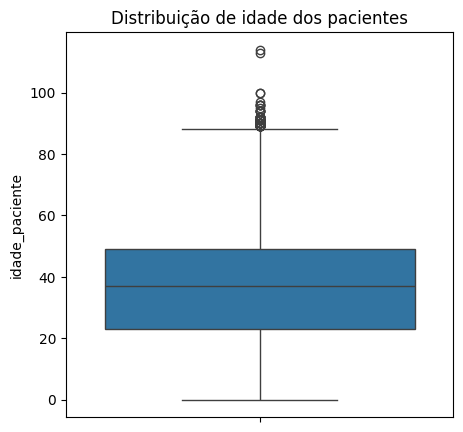

In [71]:
plt.figure(figsize=(5, 5))
sns.boxplot(y=df_psico['idade_paciente'])
plt.title('Distribuição de idade dos pacientes')
plt.show()

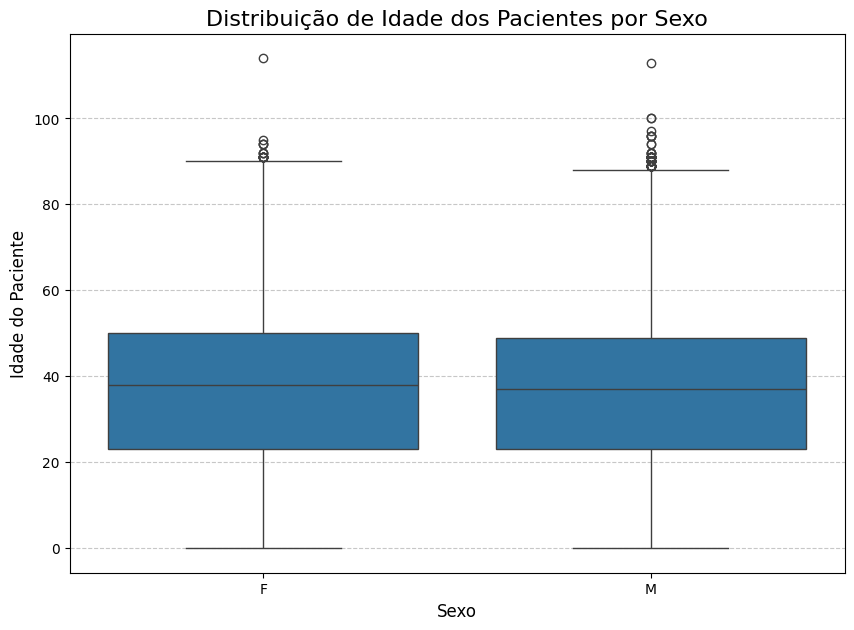

In [ ]:
plt.figure(figsize=(10, 7))

sns.boxplot(data=df_psico, x='sexo_paciente', y='idade_paciente',
            order=['F', 'M']) 

plt.title('Distribuição de idade dos pacientes por sexo', fontsize=16)
plt.xlabel('Sexo', fontsize=12)
plt.ylabel('Idade', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()